### 讀取資料

In [107]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('original_data.csv')

## 1. 資料前處理

In [108]:
# rename columns
old_col = list(df.columns)
new_col = ['time','name','gender','student_id','email','hobbies','Q1','Q2','Q3','Q4','Q5','Q6','Q7','Q8','Q9','contact','comment','homo']
df.columns = new_col
df = df.drop('homo',axis=1)
print('number of data :',len(df))

# duplicated data 
df = df.drop_duplicates(subset = 'student_id', keep = 'last')

# reset index
df.reset_index(drop =True, inplace=True)
               
df[2:3]               

number of data : 2145


,time,name,gender,student_id,email,hobbies,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,contact,comment
2,2020/10/22 下午 6:00:34,張語樵,男,b05703036,b05703036@ntu.edu.tw,電影 看劇 旅行,酒吧/夜店,實用性禮物（化妝品、衣服、皮夾...）,臉,家裡看Netflix,摩斯,貓貓,Ｓ,亞洲,新北耶誕城,chao_2404224,NaN


#### 處理興趣欄位
由於當初設計表單是並沒有嚴格規定數入資料的形式，因此興趣欄位的格式不統一，需做處理並去除不必要的動詞

In [109]:
# import models
import jieba
import jieba.posseg as pseg
jieba.set_dictionary('dict.txt')

Example hobby input : 電影 看劇 旅行


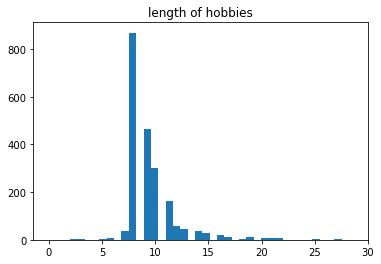

In [110]:
print('Example hobby input :',df.loc[2,'hobbies'])

plt.hist(df['hobbies'].apply(len),bins=100)
plt.xlim(right=30)
plt.title('length of hobbies')
plt.show()

In [111]:
# count hobbies
hobby_list = []
for words in df['hobbies'].values:
    words_split = words.split()
    if len(words_split) == 1 or len(words_split) == 0: # 假如沒有被split掉 則全部保留 ex : '看展露營旅遊' -> '看展露營旅遊'
        hobby_list.append(words)
    else:
        for strs in words_split:
            hobby_list.append(keep_last(strs))



def add_space(strs):
    stop_word = '/、，；,'
    for w in stop_word:
        if w in strs:
            strs = strs.replace(w,' ')
    return strs

# convert all other symbols to space
df['hobbies'] = df['hobbies'].apply(add_space)



# keep the last element ex : '我想看電影' -> '電影' / '電影' -> '電影'
def keep_last(strs):
    words = list(pseg.cut(strs))
    word = words[-1].word
    return word

# transfer to final output ex : '看展 打電腦 去旅遊' -> '看展電腦旅遊'
def hobby_output(words):
    words_split = words.split()  
    # '看電影     ' -> ['看電影'] , ['看、 電影 '] -> ['看、','電影']
    # 自動trim的功能 比.split(' ')更有效 
    
    if len(words_split) == 1 or len(words_split) == 0: # 假如沒有被split掉 則全部保留 ex : '看展露營旅遊' -> '看展露營旅遊'
        return words
    else:
        final_strs = ''
        for strs in words_split:
            final_strs += keep_last(strs)
        return final_strs
# transfer the hobbies
df['hobbies'] = df['hobbies'].apply(hobby_output)
df['hobbies'].head() 

Building prefix dict from /Users/chao/Desktop/matching code拷貝/dict.txt ...
Loading model from cache /var/folders/6k/k25tpd2n1b9342z9z0ds5w_r0000gn/T/jieba.uce2b297e721a4a48f11a31a2381d0868.cache
Loading model cost 0.928 seconds.
Prefix dict has been built successfully.


0     影集睡覺撈
1    看展露營桌遊
2    電影看劇旅行
3    電影攝影唱歌
4    電影花錢頭髮
Name: hobbies, dtype: object

## 2.建立矩陣、計算相似度
1. 問題相似度 - cosine similarity
2. 興趣相似度 - use the similarity difflib.SequenceMatcher -> (s1 and s2) / mean(len(l1),len(l2))
3. 性格配對 - S對M , M對S
4. 男女矩陣 - 男對女 , 女對男

### 問題相似度
- 使用餘弦相似度

In [115]:
# ### Get dummies for catagorical data

# cat_col = ['Q1','Q2','Q3','Q4','Q5','Q6','Q8']

# def convert2_dummies(df,col_name):
#     df_dummy = pd.get_dummies(df[col_name],prefix=col_name,drop_first=True)
#     df = pd.concat([df,df_dummy],axis = 1)
#     df.drop(col_name, axis = 1, inplace = True)
#     return df

# for col_name in cat_col:
#     df = convert2_dummies(df,col_name)
    
# create question matrix 
df_question = df[df.columns[10:]]
df_question.head(3)

,Q1_看劇,Q1_運動,Q1_酒吧/夜店,Q2_實用性禮物（化妝品、衣服、皮夾...）,Q2_浪漫小廢物 (手作卡片、禮物、娃娃),Q2_現金,Q3_臉,Q3_身材,Q3_身高,Q4_爬山,Q4_看電影,Q4_逛街逛夜市,Q5_漢堡王,Q5_肯德基,Q5_麥當勞,Q6_貓貓,Q8_歐美
0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,1
1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0
2,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0


In [120]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_matrix = cosine_similarity(df_question)
print('shape of matrix',cosine_matrix.shape)
cosine_matrix

shape of matrix (2109, 2109)


array([[1.        , 0.23570226, 0.20412415, ..., 0.        , 0.33333333,
        0.36514837],
       [0.23570226, 1.        , 0.28867513, ..., 0.        , 0.        ,
        0.        ],
       [0.20412415, 0.28867513, 1.        , ..., 0.4472136 , 0.40824829,
        0.4472136 ],
       ...,
       [0.        , 0.        , 0.4472136 , ..., 1.        , 0.54772256,
        0.4       ],
       [0.33333333, 0.        , 0.40824829, ..., 0.54772256, 1.        ,
        0.73029674],
       [0.36514837, 0.        , 0.4472136 , ..., 0.4       , 0.73029674,
        1.        ]])

### 興趣矩陣
- 使用 similarity difflib.SequenceMatcher -> (s1 and s2) / mean(len(l1),len(l2))
- 若字數相似度 < 0.3，則視其相似度為0

In [122]:
import difflib

In [124]:
l = len(df)

# create n,n matrix
hobbies_matrix = np.zeros((l,l))

# create n,1 array
hobbies_arr = np.array(df['hobbies'])

# caculate similarity
def hobby_similarity(s1,s2):
    return difflib.SequenceMatcher(None, s1, s2).quick_ratio()

# caculate similarity to matrix
hobbies_arr = np.array(df['hobbies'])
l = len(hobbies_arr)

# loop all values
for i in range(l):
    for j in range(l):
        hobbies_matrix[i,j] = hobby_similarity(hobbies_arr[i],hobbies_arr[j])    
        
# set threshold
def hobby_shreshold(x):
    if x < 0.3 :
        return 0
    else:
        return x
vecfunc = np.vectorize(hobby_shreshold)
# func to all values
hobbies_matrix_func = vecfunc(hobbies_matrix)

In [125]:
hobbies_matrix_func

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.30769231,
        0.33333333],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.30769231, ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.33333333, ..., 0.        , 0.        ,
        1.        ]])

### 性格矩陣
- 若S對M、M對S則給予值 1

In [126]:
l = len(df)

# create n,n matrix
SM_matrix = np.zeros((l,l))

# create n,1 array
SM_arr = np.array(df['Q7'])

def SM_match(t1,t2):
    if t1 != t2 :
        return 1
    else:
        return 0
    
for i in range(l):
    for j in range(l):
        SM_matrix[i][j] = SM_match(SM_arr[i],SM_arr[j])

SM_matrix

array([[0., 1., 1., ..., 0., 1., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 1., 1., ..., 0., 1., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.]])

### 性別矩陣

- 若男對女、女對男則給予值 1 

In [127]:
l = len(df)

# create n,n matrix
gender_matrix = np.zeros((l,l))

# create n,1 array
gender_arr = np.array(df['gender'])

# match rule
def gender_match(g1,g2):
    if g1 != g2 :
        return 1
    else:
        return 0
    
# create the matrix 
for i in range(l):
    for j in range(l):
        gender_matrix[i][j] = gender_match(gender_arr[i],gender_arr[j])

### 矩陣加總 算出配對相似度

In [128]:
# 給予矩陣權重
w1 = 1    # cosine
w2 = 0.5    # hobbies
w3 = 0.2    # SM
w4 = 10    # gender, 1 * w4 > 1.7 so different gender matches after sorting 

final_matrix = w1 * cosine_matrix + w2 * hobbies_matrix_func + w3 * SM_matrix + w4 * gender_matrix

In [129]:
# the max point of pair
max(np.amax(final_matrix,axis=1,))

11.58095238095238

### 取出相似度與自己最高的三位index

In [134]:
# # sort the matrix by index by row
# final_matrix_sorted = np.argsort(final_matrix,axis=1)[:,::-1]

# # create matrix storing the highest n match index
# n = 3
# topn_matrix = final_matrix_sorted[:,:3]

# # change to dataframe
# df_topn = pd.DataFrame(topn_matrix,columns=[str(i+1) for i in range(n)])

# # concat the dataframe
# df_final = pd.concat([df,df_topn],axis=1)

df_final.iloc[2]

time                      2020/10/22 下午 6:00:34
name                                        張語樵
gender                                        男
student_id                            b05703036
email                      b05703036@ntu.edu.tw
hobbies                                  電影看劇旅行
Q7                                            Ｓ
Q9                                        新北耶誕城
contact                            chao_2404224
comment                                     NaN
Q1_看劇                                         0
Q1_運動                                         0
Q1_酒吧/夜店                                      1
Q2_實用性禮物（化妝品、衣服、皮夾...）                        1
Q2_浪漫小廢物 (手作卡片、禮物、娃娃)                         0
Q2_現金                                         0
Q3_臉                                          1
Q3_身材                                         0
Q3_身高                                         0
Q4_爬山                                         0
Q4_看電影                                  

## 3.建立配對DataFrame
- 一位女性會配到三位男性  (經過檢測後，最適的配對方法)
- 一位男性會配對0至多位女性

In [135]:
from sklearn.metrics import jaccard_score

In [150]:
# check functions

# insert index, return gender
def check_gender(idx):
    idx_list = df_final.iloc[idx][['1','2','3']].values
    return df_final['gender'].iloc[idx_list]

# insert student_id, return info df for all matches
def match_info(idx):
    match_id = df_final.iloc[idx][['1','2','3']].values
    return df_final.iloc[match_id]

# insert index, return question similarity
q_matrix = df_question.to_numpy()
def question_ratio(idx1,idx2):
    return jaccard_score(q_matrix[idx1],q_matrix[idx2])

# insert index, return hobby similarity
def hobby_ratio(idx1,idx2):
    s1 = df_final.loc[idx1,'hobbies']
    s2 = df_final.loc[idx2,'hobbies']
    return hobby_similarity(s1,s2)

def check_similarity(a,b):
    print('question_similariy',question_ratio(a,b))
    print('hobby_similarity',hobby_ratio(a,b))

# 算出final matrix 的相似度
## 最大分數為 max(np.amax(final_matrix,axis=1,)) = 1.5分 因此全部同除以最大值 並取得百分比
max_point = max(np.amax(final_matrix,axis=1,))
def total_similarity(a,b):
    return (final_matrix[a][b] - 10)/(max_point-10) * 100

def get_index(data,col):
    return df_final[df_final[col] == data].index.values[0]

In [151]:
# test if df match the opposite gender
for i in range(10,15):
    print(df_final.loc[i,'gender'],':',check_gender(i).values)

男 : ['女' '女' '女']
男 : ['女' '女' '女']
男 : ['女' '女' '女']
男 : ['女' '女' '女']
男 : ['女' '女' '女']


### 建立配對字典

number of match 868
mean =  2.1463133640552994
median =  2.0
max =  18


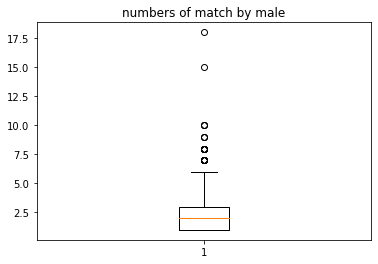

In [152]:
## merge to matches

cols = ['1','2','3']
df_final['matches'] = df_final[cols].values.tolist()
df_male = df_final[df_final['gender'] == '男']
df_female = df_final[df_final['gender'] == '女']


# Create dictionary of female matches

female_dict = {}
for i,x in df_female.iterrows():
    female_dict[i] = x['matches']

# Create dictionary of male matches

male_dict = dict()

for i, x in df_female.iterrows():
    for idx in x['matches']:
        if idx not in male_dict.keys():
            lst = []
            lst.append(i)
            male_dict[idx] = lst
        else:
            lst = male_dict[idx]
            lst.append(i)
            male_dict[idx] = lst
            
def distribution_info(arr,p):
    print('number of match',len(arr))
    print('mean = ',np.mean(arr))
    print('median = ',np.median(arr))
    print('max = ', np.max(arr))
#     print('{} percentile = {}'.format(p,np.percentile(arr,p))

male_lengths = [len(lst) for lst in list(male_dict.values())]

plt.boxplot(np.array(male_lengths),)
plt.title('numbers of match by male')
distribution_info(male_lengths,90)

#### 前100位 男性配對數量

In [153]:
n = 100
print('前%d男性位配對數量：'%n,sorted(male_lengths)[::-1][:n])

前100男性位配對數量： [18, 15, 10, 10, 10, 9, 9, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


### 建立配對資料庫

In [155]:
match_lst = []

for k,v_list in female_dict.items():
    for v in v_list:
        match_lst.append([k,v])

df_match = pd.DataFrame(np.array(match_lst), columns=['female','male'])
# add campaign (for database)
df_match['campaign'] = df_final['Q9'].values[:1863]
df_match

,female,male,campaign
0,0,1416,跨年
1,0,308,跨年
2,0,2072,新北耶誕城
3,1,989,新北耶誕城
4,1,431,新北耶誕城
...,...,...,...
1858,2092,1644,新北耶誕城
1859,2092,1358,新北耶誕城
1860,2103,1809,新北耶誕城
1861,2103,1035,新北耶誕城


In [159]:
# Combine male and female dicitonary
match_dict = female_dict.copy()
match_dict.update(male_dict)

df_output = pd.DataFrame()
df_output['index'] = match_dict.keys()
df_output['matches'] = match_dict.values()
df_output.head()

,index,matches
0,0,"[1416, 308, 2072]"
1,1,"[989, 431, 263]"
2,4,"[1356, 1483, 1412]"
3,18,"[342, 1783, 2071]"
4,20,"[1247, 1409, 653]"


## 4.輸出格式
- 建立信件輸出格式

In [160]:
# Create Chinese dictionary

output_col = ['name','hobbies','contact','Q9']
output_title = ['姓名','興趣','聯絡方式','他/她想和你一起去']
to_chinese = dict(zip(output_col,output_title))

In [168]:
# create columns for output
df_output['output'] = ''
df_output['matches'].apply(len).value_counts()

# reset index 
df_output = df_output.set_index('index')
df_output.head()

,matches,output
index,,
0,"[1416, 308, 2072]",
1,"[989, 431, 263]",
4,"[1356, 1483, 1412]",
18,"[342, 1783, 2071]",
20,"[1247, 1409, 653]",


In [221]:
# 修改範例資料
df_final.loc[1548,'contact'] = 'Line : 12345678'

# 建立輸出output
for idx1,row in df_output.iterrows():
    match_lst = row['matches']
    # index list
    output2 = '您好 感謝您填寫台大交流版的交友配對表單 \r\n此份配對才是最終結果 \r\n以下是您的配對 \r\n \r\n'
    for idx2 in match_lst:
#         print(idx1,idx2)
        output1 = ''
        #single idx
        for col in output_col:
            # col info
            output1 += '{} : {}\r\n'.format(to_chinese[col],df_final.loc[idx2,col])
            # ratio info
        output1 += '配對相似度 : {} %\r\n'.format(round(total_similarity(idx1,idx2),1))
        output2 += output1 + '\r\n'

    df_output.loc[idx1,'output'] = output2

### 範例信件輸出
由於個資問題 這邊僅呈現修改過的假資料

In [224]:
df_final[2:3]

,time,name,gender,student_id,email,hobbies,Q7,Q9,contact,comment,...,Q4_逛街逛夜市,Q5_漢堡王,Q5_肯德基,Q5_麥當勞,Q6_貓貓,Q8_歐美,1,2,3,matches
2,2020/10/22 下午 6:00:34,張語樵,男,b05703036,b05703036@ntu.edu.tw,電影看劇旅行,Ｓ,新北耶誕城,chao_2404224,NaN,...,0,0,0,0,1,0,879,126,688,"[879, 126, 688]"


In [223]:
df_output.head()

,matches,output
index,,
0,"[1416, 308, 2072]",您好 感謝您填寫台大交流版的交友配對表單 \r\n此份配對才是最終結果 \r\n以下是您的配...
1,"[989, 431, 263]",您好 感謝您填寫台大交流版的交友配對表單 \r\n此份配對才是最終結果 \r\n以下是您的配...
4,"[1356, 1483, 1412]",您好 感謝您填寫台大交流版的交友配對表單 \r\n此份配對才是最終結果 \r\n以下是您的配...
18,"[342, 1783, 2071]",您好 感謝您填寫台大交流版的交友配對表單 \r\n此份配對才是最終結果 \r\n以下是您的配...
20,"[1247, 1409, 653]",您好 感謝您填寫台大交流版的交友配對表單 \r\n此份配對才是最終結果 \r\n以下是您的配...


In [251]:
# sample output
n=5
print(df_final.loc[n,'gender'])
print(df_output.loc[n,'output'])

男
您好 感謝您填寫台大交流版的交友配對表單 
此份配對才是最終結果 
以下是您的配對 
 
姓名 : 安安你好
興趣 : 貓團動漫
聯絡方式 : Line : 12345678
他/她想和你一起去 : 新北耶誕城
配對相似度 : 67.4 %




### To csv file 

In [236]:
### drop df_final['matches']  因為他是男女各對三位
df_final_output = pd.concat([df_final.drop('matches',axis=1),df_output],axis=1)
df_final_output.to_csv('df_final_output.csv',index=False)

## 5.寄出信件

In [241]:
df_final_output = pd.read_csv('df_final_output.csv')

df_unmatch = df_final_output[pd.isna(df_final_output['matches'])]
df_match = df_final_output[pd.notna(df_final_output['matches'])]

# 當dataframe裡的list轉成csv檔時，csv會將其儲存成'[1,2,3]' 而不是[1,2,3]，因此利用json處理
df_match['matches'] = df_match['matches'].apply(lambda x: json.loads(x))

### 確認性別是否正確！！！！！

In [246]:
for check_idx,row in df_final_output_Y.iterrows():
    # 配對本人的性別
    host_gender = df_final_output_Y.loc[check_idx,'gender']
    
    match_list = df_final_output_Y.loc[check_idx,'matches']
    # 配對的idx
    for idx in match_list:
        guest_gender = df_final_output_Y.loc[idx,'gender']
        # 若男男、女女則print值
        if host_gender == guest_gender:
            print('{} and {} unmatch!'.format(host_gender,guest_gender))

### 寄信給成功配對的人

In [248]:
## reset_index ㄖ
df_match = df_match.reset_index()

# Correct invalid Emails
df_match.loc[770,'email'] = 'b08303028@ntu.edu.tw'
df_match.loc[1320,'email'] = 'wd97410001@gmail.com'

email_list = list(df_match['email'].values)

# check invalid emails

for i in range(len(email_list)):
    if '@' not in email_list[i]:
        print(i,email_list[i])

In [249]:
import smtplib
import time
from email.mime.multipart import MIMEMultipart #email內容載體
from email.mime.text import MIMEText #用於製作文字內文
from email.mime.base import MIMEBase #用於承載附檔
from email import encoders #用於附檔編碼
import datetime
import ssl

#寄件者使用的Gmail帳戶資訊
gmail_user = 's2404224@gmail.com'
gmail_password = 'chao2404224'
from_address = gmail_user

#設定信件內容與收件人資訊 - loop
to_address_list = df_match['email'].values.tolist()
Subject = "台大交友配對結果"
contents_list = df_match['output'].values.tolist()

In [527]:
# 設定smtp伺服器並寄發信件    
smtpserver = smtplib.SMTP_SSL("smtp.gmail.com", 465)
smtpserver.ehlo()
smtpserver.login(gmail_user, gmail_password)


count = 0
for i in range(1397,1398):
    #開始組合信件內容
    mail = MIMEMultipart()
    mail['From'] = from_address
    mail['To'] = to_address_list[i]
    mail['Subject'] = Subject
    #將信件內文加到email中
    contents = contents_list[i]
    mail.attach(MIMEText(contents))     
    count += 1
    if check_gender(i):
        print(count)
        smtpserver.sendmail(from_address, to_address_list[i], mail.as_string())
    

# smtpserver.quit()
end = time.time()
print('cost {} seconds for sending {} email'.format(end-start,count))